# **Qiskit Global Hackathon** 
# Quantum Anomaly Detection with Quantum Density Estimation

## Data Load

We will work with the following datasets: 

*   SpamBase: dataset from UCI Machine Learning Repository, includes 3485 emails classified as spam or non-spam. This dataset has 58 attributes. We treat spam as outliers. The anomaly ratio is 0.2
*   Cardiotocography: data is also from UCI Machine Learning Repository and is related to heart diseases. This dataset contains 22 attributes. It describes 3
classes: normal, suspect, and pathological. Normal patients are treated as inliers and the remaining as outliers. The anomaly ratio is 0.2



### Imports and Libraries

In [3]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.1 MB 5.0 MB/s 
     |████████████████████████████████| 17.9 MB 112 kB/s 
     |████████████████████████████████| 237 kB 43.6 MB/s 
     |████████████████████████████████| 207 kB 47.4 MB/s 
     |████████████████████████████████| 2.1 MB 56.4 MB/s 
     |████████████████████████████████| 1.4 MB 54.0 MB/s 
     |████████████████████████████████| 634 kB 52.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 943 kB 10 kB/s 
     |████████████████████████████████| 3.5 MB 44.6 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.0-py3-none-any.whl size=11773 sha256=0e0a8f61973bfacbfac251dd07a663d0f6707738f0cbc5e4e4014557db3dbd72
  Stored in directory: /root/.cache/pip/wheels/95/84/c4/6a084a33c1909266fca66eed2303c3883e03f33c905b1eb

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

### Load from Drive

In [6]:
#Loading SpamBase dataset file
!gdown --id 1Hdq-Svp31YkTj7wFZY3D2fsnBM1tbr_t

Downloading...
From: https://drive.google.com/uc?id=1Hdq-Svp31YkTj7wFZY3D2fsnBM1tbr_t
To: /content/SpamBase.npy
100% 1.65M/1.65M [00:00<00:00, 52.5MB/s]


In [7]:
#Loading Cardiotocography dataset file
!gdown --id 1sVygYNPrTQI9d-8kVnx7w5nGWOSosveX

Downloading...
From: https://drive.google.com/uc?id=1sVygYNPrTQI9d-8kVnx7w5nGWOSosveX
To: /content/Cardiotocography.npy
100% 379k/379k [00:00<00:00, 79.9MB/s]


In [8]:
spambase = np.load("SpamBase.npy")

cardio = np.load("Cardiotocography.npy")

### Preprocessing

This function extracts and separates the features and the labels from the whole dataset. We will apply it to both datasets. Normal data will be labeled as '1' and anomalies will be labeled as '0'.

In [9]:
from sklearn.preprocessing import MinMaxScaler

def preprocessing(data):
    features = data[:,:-1]
    labels = data[:,-1]

    scaler = MinMaxScaler()
    scaler.fit(features)
    features = scaler.transform(features)

    labels = labels[:,np.newaxis]
    labels[labels == -1] = 0

    return features, labels

In [10]:
spam_X, spam_y = preprocessing(spambase)
cardio_X, cardio_y = preprocessing(cardio)

In [11]:
spam_X.shape

(3485, 58)

In [12]:
cardio_X.shape

(2060, 22)

## Random Fourier Features

To perform dimensionality reduction, we will use Random Fourier Features, an approach stablished by Rahimi and Recht, 2007. RFF is a type of quantum feature map from data to quantum states, in such a way that it can fit more precisely the underlying probability distribution of data.


In [13]:
from sklearn.kernel_approximation import RBFSampler
"""
  Code from https://arxiv.org/abs/2004.01227
"""
class QFeatureMap: 

  def get_dim(self, num_features):
    pass

  def batch2wf(self, X):
    pass

  def batch2dm(self, X):
    pass

  def batch2dm(self, X):
    psi = self.batch2wf(X)
    rho = np.einsum('...i,...j', psi, np.conj(psi))
    return rho

class QFeatureMap_rff(QFeatureMap):

  def __init__(self, rbf_sampler):
    self.rbf_sampler = rbf_sampler
    self.weights = np.array(rbf_sampler.random_weights_)
    self.offset = np.array(rbf_sampler.random_offset_)
    self.dim = rbf_sampler.get_params()['n_components']

  def get_dim(self, num_features):
    return self.dim

  def batch2wf(self, X):
    vals = np.dot(X, self.weights) + self.offset
    vals = np.cos(vals)
    vals *= np.sqrt(2.) / np.sqrt(self.dim)
    norms = np.linalg.norm(vals, axis=1)
    psi = vals / norms[:, np.newaxis]
    return psi

## Cardio 4x4 Mixed State

First, we will work with Cardiotocography dataset.

The number of RFF we will use depends on the size of the density matrix we will build. In this case, we will use a 4x4 density matrix, so we will reduce our samples to arrays of length 4. Transforming each sample will allow us to convert those values into two-qubit states. 

In [14]:
# Create the RandomFourierFeature map
dim = 4
rm_state = 2
sigma = 1.5  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(cardio_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Crff = rffmap.batch2wf(cardio_X)

print(Crff.shape)

(2060, 4)


Once our samples have been reduced, it's important to normalize them. Also we will split the dataset into three groups, a training partition with only normal data (70%), and a test partition with a group of normal data (10%) and a group of outlier data (20%).

In [15]:
Cones = []
Ctrain = []
Ctest_zeros = []
Ctest_ones = []

for i in range(Crff.shape[0]):
    if (cardio_y[i] == 1):
        Cones.append(Crff[i] / np.linalg.norm(Crff[i]))
    elif (cardio_y[i] == 0):
        Ctest_zeros.append(Crff[i] / np.linalg.norm(Crff[i]))

Ctest_ones = Cones[:len(Ctest_zeros)//2]
Ctrain = Cones[len(Ctest_zeros)//2:]

print(len(Ctrain))
print(len(Ctest_zeros))
print(len(Ctest_ones))

1442
412
206


In [16]:
print(Ctrain[0])
print(sum(Ctrain[0]**2))

[ 0.6607845   0.60963091 -0.29528374 -0.32329786]
1.0000000000000002


Now, we will define the training state using the Mixed State approach. We will use the density matrix corresponding to the training state, $\rho_1$. So we have

$$
\rho_1 = \frac{1}{m} \sum |\phi_1 \rangle \langle \phi_1 |
$$

being $|\phi_1 \rangle$ the states labeled with '1' (aka training normal data), and $m$ the amount of samples. To construct the density matrices, only train samples will be used.

In [17]:
import copy
def round_lambda(lambda_param_2):
  lambda_param = copy.copy(lambda_param_2)
  for i in range(4):
    if lambda_param[i] < 0.00000001:
      lambda_param[i] = 0.00000001
  lambda_param[3] = 1 - lambda_param[0] - lambda_param[1] - lambda_param[2]
  return lambda_param

In [18]:
Z_train = np.outer(np.abs(Ctrain[0]), np.abs(Ctrain[0]))
for i in range(1, len(Ctrain)):
    Z_train += np.outer(np.abs(Ctrain[i]), np.abs(Ctrain[i]))

Z_train *= 1/len(Ctrain)
print(Z_train)

[[0.28539094 0.21797308 0.12163383 0.28368129]
 [0.21797308 0.20571635 0.10524944 0.25986083]
 [0.12163383 0.10524944 0.08864394 0.14422189]
 [0.28368129 0.25986083 0.14422189 0.42024877]]


In [19]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.01929039 0.02967972 0.06373443 0.88729546]
[[ 0.41964602 -0.29678184 -0.67344497 -0.53130936]
 [-0.87135899 -0.04328634 -0.15939879 -0.46200847]
 [ 0.11676352  0.94808647 -0.13909626 -0.26105661]
 [ 0.22582516 -0.10573021  0.70831923 -0.66038473]]


In [20]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.02166764 0.0333373  0.07158875 0.99664145]
0.9999999999999999


The quantum circuit we propose will be based in a Qiskit gate called `Isometry`, that allows to prepare arbitrary unitary rotations.

We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density value estimated by the circuit.

In [21]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [22]:
## Density Estimation Approach matrices 4x4
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(4, 2)

    qc.initialize(Ctest_ones[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_ones.append((counts['00'])/5000)

print(Cpred_ones)

[0.214, 0.0926, 0.0502, 0.1488, 0.0394, 0.024, 1.7982, 0.139, 0.215, 0.0768, 0.8086, 0.0146, 1.2966, 0.3184, 0.5238, 0.0308, 1.652, 1.8776, 1.1904, 1.6002, 2.102, 1.6478, 2.3404, 3.03, 1.912, 0.6914, 2.5166, 0.8448, 1.0294, 1.9948, 1.7792, 2.6616, 0.1438, 0.2088, 0.365, 0.016, 0.0134, 0.0192, 0.0416, 0.0148, 0.0114, 0.4522, 0.0524, 0.0104, 0.025, 0.0088, 0.0356, 0.0512, 0.0162, 0.0168, 0.0122, 0.032, 0.0128, 0.0122, 0.0154, 0.0136, 0.0238, 0.023, 0.0346, 0.0196, 0.0152, 0.0166, 0.0266, 0.0202, 0.0176, 2.2426, 0.406, 0.7414, 0.1448, 0.3144, 0.185, 0.1002, 0.4938, 1.2452, 0.8562, 0.1414, 1.4406, 0.7256, 0.4566, 0.2614, 2.3354, 2.038, 0.7778, 0.8568, 1.2222, 2.0038, 1.44, 0.977, 1.8636, 0.0114, 0.0584, 0.0152, 0.0418, 0.0548, 0.0428, 0.0394, 0.07, 0.0514, 0.0114, 0.0216, 0.0282, 0.013, 0.0132, 0.012, 0.0152, 0.0102, 0.0154, 0.1048, 0.8522, 0.6226, 1.0562, 0.994, 0.9546, 2.4066, 1.6386, 1.971, 1.9234, 0.4604, 1.1696, 0.8214, 0.0248, 0.0176, 0.022, 0.0766, 1.7426, 1.5724, 1.8348, 0.6992, 0.

In [23]:
# Mixed state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(4, 2)
    
    qc.initialize(Ctest_zeros[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_zeros.append((counts['00'])/5000)

print(Cpred_zeros)

[0.0684, 0.1196, 0.0228, 0.0174, 0.0092, 0.5514, 0.789, 0.0748, 0.0082, 0.0876, 1.1682, 0.0102, 1.1918, 0.0184, 0.04, 0.1338, 0.3542, 0.2672, 0.248, 0.28, 0.011, 0.0152, 0.0174, 0.5672, 0.2106, 0.0248, 0.009, 0.021, 0.0268, 0.041, 0.2644, 0.3378, 0.016, 0.7752, 1.2374, 0.5204, 0.0172, 0.0104, 0.0708, 0.037, 0.1128, 0.0136, 0.0252, 0.115, 0.0616, 0.6658, 0.0126, 0.2878, 0.0214, 0.0672, 0.0874, 0.0114, 0.0582, 0.3758, 0.009, 0.2992, 0.0364, 0.1518, 0.0722, 0.3478, 0.111, 0.0648, 0.5902, 0.0242, 1.0012, 0.0164, 0.0106, 0.2602, 0.0152, 0.0772, 1.1338, 0.593, 0.0168, 0.8484, 0.0268, 0.0232, 0.0114, 0.0176, 0.4136, 0.7822, 0.3392, 0.0552, 1.6286, 0.7188, 0.1488, 0.0286, 0.0144, 0.0146, 0.84, 0.3134, 0.014, 0.015, 0.0148, 0.064, 0.06, 0.117, 0.056, 0.0116, 0.1024, 1.4278, 0.0128, 0.2292, 0.026, 0.0262, 0.069, 0.356, 0.0104, 0.0924, 0.0272, 0.015, 0.0238, 0.0434, 0.474, 0.0202, 0.0856, 0.0202, 0.0542, 0.063, 0.3098, 0.0218, 0.0302, 0.028, 0.405, 0.0528, 0.0622, 0.1258, 0.0154, 0.0336, 0.0142, 

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density value lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples (based on the best possible value of weighted F1-score). After that, we'll use this threshold to compare with all the remaining test samples. 

In [24]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.5988


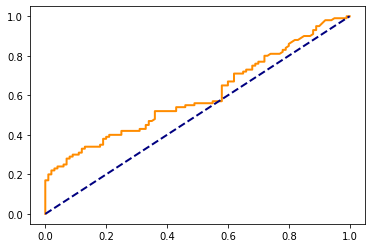

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [26]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.3758


We have obtained that our best threshold is at $t = 0.3758$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [27]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8431    0.8782    0.8603       312
         1.0     0.5914    0.5189    0.5528       106

    accuracy                         0.7871       418
   macro avg     0.7172    0.6985    0.7065       418
weighted avg     0.7793    0.7871    0.7823       418



## Cardio 4x4 Pure State


Now, we will define another way to represent the training density matrix: the Pure State approach. First, we will define the state  $|\psi_1 \rangle$. 

$$
 |\psi_1 \rangle = \frac {\sum |\phi_1 \rangle} {\left \| \sum |\phi_1 \rangle \right \|}
$$

being $|\phi_1 \rangle$ the states labeled with '1'. To construct this state, only train samples will be used.

Once obtained this state, it represents all the information from training states. So we build the density matrix as

$$
\rho_1 = |\psi_1 \rangle \langle ψ_1 |
$$

In [29]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |lambda>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U))
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i = np.random.randn(size_U)
    for j in range(0, i):
      x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i
  
  return U_train

In [30]:
phi_train = np.sum(np.abs(Ctrain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 0.53308287  0.2309175   0.69538315 -0.42301541]
 [ 0.46304288 -0.88279704 -0.0144998   0.07778448]
 [ 0.26452084  0.21352962  0.27364652  0.89975075]
 [ 0.65684295  0.34892921 -0.66434149 -0.0738656 ]]


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [31]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [32]:
## Density Estimation Approach matrices 4x4
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Ctest_ones[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_ones.append((counts['00'])/5000)
    except:
        Cpred_ones.append(0)

print(Cpred_ones)

[0.1996, 0.0846, 0.0454, 0.1368, 0.0266, 0.0068, 1.7762, 0.1236, 0.1914, 0.0546, 0.7986, 0.0002, 1.3286, 0.3082, 0.517, 0.0216, 1.6652, 1.8668, 1.1788, 1.6422, 2.1298, 1.619, 2.3728, 3.0332, 1.9352, 0.6874, 2.5484, 0.8588, 1.027, 1.9708, 1.777, 2.684, 0.1366, 0.2012, 0.3582, 0.0082, 0.0026, 0.0086, 0.0328, 0.0034, 0.0002, 0.465, 0.047, 0.0022, 0.0084, 0.001, 0.0262, 0.0354, 0.0022, 0.0048, 0.0014, 0.0186, 0.0008, 0, 0.0024, 0, 0.0054, 0.0094, 0.0206, 0.0118, 0.001, 0.0034, 0.0152, 0.01, 0.0068, 2.2896, 0.3976, 0.7394, 0.1436, 0.3064, 0.1648, 0.0842, 0.4678, 1.239, 0.8436, 0.1286, 1.4268, 0.7234, 0.4642, 0.2516, 2.3294, 2.0588, 0.7798, 0.8872, 1.2348, 2.0036, 1.4612, 0.9752, 1.8852, 0.0006, 0.0474, 0.005, 0.0296, 0.0446, 0.0286, 0.0298, 0.0688, 0.038, 0.0006, 0.0078, 0.0192, 0.002, 0, 0.0002, 0.0032, 0.002, 0.0016, 0.1096, 0.8788, 0.6206, 1.0462, 1.0264, 0.9898, 2.4422, 1.668, 1.985, 1.9574, 0.4466, 1.187, 0.8152, 0.0114, 0.0078, 0.0104, 0.0622, 1.7514, 1.582, 1.8674, 0.7056, 0.649, 1.2

In [33]:
# Pure state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Ctest_zeros[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_zeros.append((counts['00'])/5000)
    except:
        Cpred_zeros.append(0)

print(Cpred_zeros)

[0.0598, 0.1026, 0.0114, 0.0046, 0.0002, 0.556, 0.8118, 0.0616, 0, 0.0732, 1.194, 0, 1.2268, 0.0088, 0.0272, 0.127, 0.3356, 0.2658, 0.2252, 0.2706, 0.0002, 0.0048, 0.0056, 0.5674, 0.1846, 0.008, 0, 0.0084, 0.013, 0.0212, 0.2624, 0.3156, 0.0086, 0.8002, 1.223, 0.5228, 0.006, 0, 0.0554, 0.0276, 0.1162, 0, 0.0146, 0.1088, 0.038, 0.6774, 0, 0.29, 0.011, 0.0558, 0.0818, 0, 0.045, 0.3692, 0.0004, 0.315, 0.0282, 0.1598, 0.0712, 0.3218, 0.086, 0.0512, 0.5896, 0.0152, 0.9942, 0, 0.0004, 0.261, 0.0052, 0.0766, 1.1412, 0.62, 0, 0.842, 0.0176, 0.0182, 0.0004, 0.0142, 0.3906, 0.7982, 0.3298, 0.0412, 1.6536, 0.727, 0.1456, 0.0172, 0, 0.0072, 0.8646, 0.319, 0.0042, 0.0018, 0.0024, 0.0574, 0.0498, 0.098, 0.041, 0.0002, 0.0984, 1.4236, 0.0002, 0.232, 0.0134, 0.0162, 0.0604, 0.353, 0, 0.082, 0.0126, 0.0056, 0.012, 0.0444, 0.452, 0.0042, 0.074, 0.0086, 0.047, 0.066, 0.311, 0.012, 0.0176, 0.0048, 0.4014, 0.034, 0.0452, 0.128, 0.0084, 0.0138, 0.0014, 0.1082, 0.8632, 0.0014, 0.2948, 0.0034, 0.0724, 0.044, 0

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ (based on weighted F1-score) using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [34]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.599


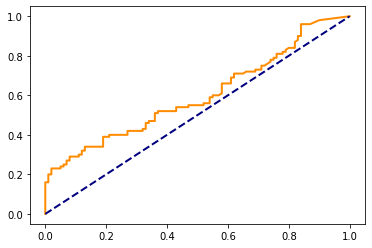

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [36]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.3692


We have obtained that our best threshold is at $t = 0.3692$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [37]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8431    0.8782    0.8603       312
         1.0     0.5914    0.5189    0.5528       106

    accuracy                         0.7871       418
   macro avg     0.7172    0.6985    0.7065       418
weighted avg     0.7793    0.7871    0.7823       418



## Cardio 8x8 Mixed State

Now, we will use a 8x8 density matrix, so we will call a new RFF sampler to reduce our samples to arrays of length 8. Transforming each sample will allow us to convert those values into three-qubit states. 

In [39]:
# Create the RandomFourierFeature map
dim = 8
rm_state = 2
sigma = 1.5  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(cardio_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Crff = rffmap.batch2wf(cardio_X)

print(Crff.shape)

(2060, 8)


Once our samples have been reduced, it's important to normalize them. Also we will split the dataset into three groups, a training partition with only normal data (70%), and a test partition with a group of normal data (10%) and a group of outlier data (20%).

In [40]:
Cones = []
Ctrain = []
Ctest_zeros = []
Ctest_ones = []

for i in range(Crff.shape[0]):
    if (cardio_y[i] == 1):
        Cones.append(Crff[i] / np.linalg.norm(Crff[i]))
    elif (cardio_y[i] == 0):
        Ctest_zeros.append(Crff[i] / np.linalg.norm(Crff[i]))

Ctest_ones = Cones[:len(Ctest_zeros)//2]
Ctrain = Cones[len(Ctest_zeros)//2:]

print(len(Ctrain))
print(len(Ctest_zeros))
print(len(Ctest_ones))

1442
412
206


In [41]:
print(Ctrain[0])
print(sum(Ctrain[0]**2))

[ 0.45302627  0.48066672  0.39341633  0.02643167 -0.45585263  0.42733187
  0.13250014  0.01677011]
0.9999999999999999


Then we build our traning matrix $ρ_1$:

In [42]:
Z_train = np.outer(np.abs(Ctrain[0]), np.abs(Ctrain[0]))
for i in range(1, len(Ctrain)):
    Z_train += np.outer(np.abs(Ctrain[i]), np.abs(Ctrain[i]))

Z_train *= 1/len(Ctrain)
print(Z_train)

[[0.09403968 0.11342847 0.11443919 0.08022018 0.11041908 0.10061245
  0.03776868 0.07929061]
 [0.11342847 0.1772893  0.17837182 0.11881422 0.17201055 0.15747309
  0.05284141 0.11505695]
 [0.11443919 0.17837182 0.18674813 0.12177096 0.17508085 0.16288168
  0.05327093 0.12032412]
 [0.08022018 0.11881422 0.12177096 0.10021428 0.11710474 0.11107623
  0.03627804 0.07623142]
 [0.11041908 0.17201055 0.17508085 0.11710474 0.17365567 0.15717696
  0.0512283  0.1112635 ]
 [0.10061245 0.15747309 0.16288168 0.11107623 0.15717696 0.15136805
  0.04690002 0.10472527]
 [0.03776868 0.05284141 0.05327093 0.03627804 0.0512283  0.04690002
  0.02382305 0.03774223]
 [0.07929061 0.11505695 0.12032412 0.07623142 0.1112635  0.10472527
  0.03774223 0.09286184]]


In [43]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.00249992 0.00366071 0.00566582 0.98817355 0.01189256 0.01993744
 0.02346068 0.92597342]
[[-0.01908266 -0.10728949  0.09923328  0.2770666   0.37310267  0.46527216
  -0.68053859  0.28756759]
 [ 0.69899499  0.06961987 -0.44261374 -0.18261394  0.26442004 -0.11875085
   0.07720354  0.43280965]
 [-0.43307213 -0.64715466 -0.33970307  0.10127081 -0.04834919 -0.24078409
   0.1023804   0.44405974]
 [-0.04540449  0.13002963 -0.17242185 -0.06056506 -0.49554992  0.72782953
   0.28459714  0.30221221]
 [-0.47655819  0.59840474  0.09469492 -0.0740207   0.39542259 -0.11473368
   0.22125313  0.42647635]
 [ 0.29721548 -0.20047704  0.74998691  0.23256838 -0.08768977 -0.08546069
   0.28817368  0.39606364]
 [-0.07575347 -0.19022164  0.2772552  -0.89716308 -0.03936614  0.03101793
  -0.23699     0.1327744 ]
 [ 0.01566788  0.33684065 -0.02829192  0.1072084  -0.61430518 -0.40034708
  -0.50126668  0.291688  ]]


In [44]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.00184545 0.00270234 0.00418252 0.72947213 0.00877911 0.01471787
 0.01731873 0.68355584]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|000 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [45]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [46]:
## Density Estimation Approach matrices 8x8
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Ctest_ones[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_ones.append((counts['000'])/5000)

print(Cpred_ones)

[0.6158, 0.743, 0.7676, 0.6516, 0.7004, 0.5738, 0.3952, 0.2466, 0.4458, 0.432, 0.392, 0.3572, 0.0706, 0.0992, 0.0232, 0.3182, 0.268, 0.2286, 0.2898, 0.2514, 0.2774, 0.2286, 0.2708, 0.2238, 0.3276, 0.4232, 0.3984, 0.1948, 0.1398, 0.257, 0.1746, 0.0412, 1.3336, 1.1856, 0.1764, 0.8602, 0.8536, 0.8698, 0.8702, 0.8246, 0.5788, 0.7808, 0.9938, 0.8766, 1.0566, 0.7624, 1.0942, 1.0146, 0.5646, 0.55, 0.513, 0.536, 0.6804, 0.7148, 0.9138, 0.8002, 0.6806, 0.6782, 0.5028, 0.8026, 0.6796, 0.5996, 0.5652, 0.836, 0.8854, 0.2854, 0.5158, 0.5414, 0.5782, 0.568, 0.5482, 0.3956, 0.2572, 0.4906, 0.422, 0.581, 0.476, 0.4792, 0.689, 0.6464, 0.1642, 0.0874, 0.5432, 0.5586, 0.4826, 0.6322, 0.4702, 0.4466, 0.4402, 1.1046, 0.961, 1.109, 0.9828, 1.5206, 1.3786, 1.3758, 0.9738, 0.2846, 0.5484, 0.6896, 0.635, 0.8386, 1.007, 0.8082, 1.0682, 1.0578, 1.0168, 0.6166, 0.512, 0.5992, 0.5676, 0.5248, 0.5272, 0.2412, 0.5152, 0.3008, 0.3134, 0.4864, 0.4674, 0.5556, 0.5282, 0.5244, 0.6492, 0.4836, 0.4874, 0.4346, 0.4864, 0.5

In [47]:
# Mixed state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Ctest_zeros[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_zeros.append((counts['000'])/5000)

print(Cpred_zeros)

[1.2566, 0.8392, 0.823, 0.868, 0.692, 0.2758, 0.4006, 0.4426, 0.7928, 0.2826, 0.417, 1.2288, 0.1878, 0.6434, 0.674, 0.4046, 0.406, 0.3468, 0.2662, 0.338, 0.751, 0.8, 0.7308, 0.4616, 0.413, 0.3488, 0.7376, 0.796, 0.3672, 0.3688, 0.56, 0.504, 0.4114, 0.1402, 0.2516, 0.1738, 0.8018, 0.4604, 0.3956, 0.387, 0.631, 0.6238, 0.6196, 0.5906, 0.3412, 0.5356, 0.6682, 0.5734, 0.866, 0.6056, 0.5622, 0.8014, 1.2236, 0.483, 0.7098, 0.1732, 0.593, 0.2206, 0.8026, 0.4662, 0.7884, 0.3162, 0.4838, 0.667, 0.3612, 0.304, 0.7814, 0.4824, 0.5766, 0.617, 0.4032, 0.4908, 0.859, 0.4014, 0.732, 0.9402, 0.5302, 0.6352, 0.2528, 0.4224, 0.5464, 0.7854, 0.3786, 0.4862, 0.4392, 0.7524, 0.6824, 0.7852, 0.4416, 0.4924, 0.9034, 0.8302, 0.8522, 0.779, 1.1684, 0.3416, 0.991, 0.728, 0.7612, 0.421, 0.796, 0.622, 0.6702, 0.3504, 0.5222, 0.4788, 0.6306, 0.541, 0.7512, 1.072, 0.4098, 0.6652, 0.2902, 0.8412, 0.716, 0.9194, 1.1188, 0.6078, 0.3336, 0.8592, 0.3268, 0.3844, 0.8128, 0.651, 0.3386, 0.3244, 0.8476, 0.1844, 0.9834, 0.4

Once we have obtained the predicted density values, we need to determine the best possible threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. 

In [48]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.4949


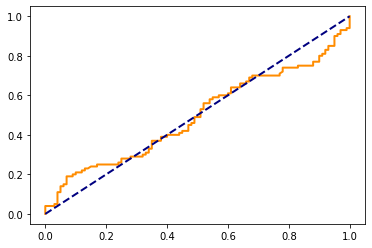

In [49]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [50]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.504


We have obtained that our best threshold is at $t = 0.504$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [51]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [52]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.7627    0.4327    0.5521       312
         1.0     0.2656    0.6038    0.3689       106

    accuracy                         0.4761       418
   macro avg     0.5141    0.5182    0.4605       418
weighted avg     0.6366    0.4761    0.5057       418



## Cardio 8x8 Pure State

Now, we'll build a new training density matrix of size 8x8 using the Pure State approach.

In [54]:
phi_train = np.sum(np.abs(Ctrain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 0.28684681  0.36163466 -0.64907043  0.3039476   0.29823376 -0.3628901
   0.15672877 -0.16752971]
 [ 0.43304774 -0.19150853  0.0425077   0.01946241 -0.66638594 -0.35659966
  -0.20048597 -0.40271614]
 [ 0.44413513 -0.01120385 -0.3346563   0.02332315 -0.35547746  0.59271958
   0.24672536  0.38926279]
 [ 0.30137368  0.50622778  0.63860468  0.26581483  0.02231948  0.06976633
   0.39028257 -0.1294136 ]
 [ 0.42656204  0.29150598  0.0298679  -0.72831994  0.27817334  0.09661608
  -0.32529554 -0.09588955]
 [ 0.39638647 -0.61313144  0.11383773  0.26809529  0.49785862  0.24052065
  -0.04173887 -0.27323611]
 [ 0.13336378  0.21047524  0.11205656  0.46037306  0.02482021  0.01655667
  -0.74680723  0.39345019]
 [ 0.29196429 -0.26635886  0.17516306 -0.14753714  0.1194335  -0.5634755
   0.23825873  0.6346844 ]]


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|000 \rangle$ obtained.

In [55]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [56]:
## Density Estimation Approach matrices 8x8
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Ctest_ones[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_ones.append((counts['000'])/5000)
    except:
        Cpred_ones.append(0)

print(Cpred_ones)

[0.9972, 1.0788, 1.6072, 1.3666, 1.4166, 0.9676, 0.7016, 0.5316, 0.9614, 0.788, 0.8074, 0.7514, 0.0936, 0.184, 0.0048, 0.6736, 0.5016, 0.516, 0.614, 0.522, 0.5276, 0.4564, 0.519, 0.4862, 0.5398, 0.9204, 0.8346, 0.2472, 0.2198, 0.5188, 0.3886, 0.097, 2.6466, 2.114, 0.3388, 1.528, 1.5558, 1.627, 1.7316, 1.468, 0.961, 1.6716, 2.1504, 1.5992, 2.1858, 1.132, 2.0886, 1.8576, 0.5808, 0.6922, 0.7006, 0.8884, 1.0064, 1.476, 1.2724, 1.5806, 1.3642, 1.271, 0.9146, 1.2752, 1.0596, 1.128, 0.7844, 1.2136, 1.4796, 0.5912, 0.8188, 1.1646, 1.1686, 0.8986, 1.1284, 0.5898, 0.3636, 0.958, 0.764, 1.2312, 0.9598, 0.9942, 1.1646, 1.2284, 0.2284, 0.1846, 0.9286, 0.9622, 0.9002, 1.296, 0.9326, 0.9196, 0.9038, 1.9562, 1.5008, 1.647, 1.632, 2.831, 2.5038, 2.5202, 1.4688, 0.6234, 1.1932, 1.478, 1.0878, 1.7112, 1.8224, 1.3848, 2.2418, 2.0818, 2.0494, 1.3278, 0.5314, 0.712, 1.0108, 1.0268, 0.9248, 0.2974, 0.9328, 0.4178, 0.4338, 0.8582, 0.86, 1.1726, 0.3538, 0.3598, 0.4358, 0.67, 1.068, 0.9186, 0.9238, 0.9172, 0.93

In [57]:
# Pure state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Ctest_zeros[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_zeros.append((counts['000'])/5000)
    except:
        Cpred_zeros.append(0)

print(Cpred_zeros)

[1.9668, 1.5754, 1.1734, 1.5554, 1.0302, 0.4776, 0.8382, 0.0148, 1.6616, 0.5102, 0.222, 2.0816, 0.2726, 0.9778, 1.1416, 0.0964, 0.0302, 0.5978, 0.0792, 0.7052, 1.4324, 1.0488, 1.2854, 0.901, 0.776, 0.6954, 1.4032, 1.3468, 0.4798, 0.7234, 1.0234, 0.952, 0.0068, 0.0656, 0.4422, 0.1028, 1.4892, 0.51, 0.6576, 0.7458, 1.1822, 0.9592, 1.1216, 1.0438, 0.5476, 1.132, 1.0804, 1.0708, 1.3552, 1.0736, 1.0506, 1.4146, 1.4974, 0.9296, 1.3532, 0.172, 1.105, 0.3474, 1.526, 0.9158, 1.3762, 0.5742, 1.0202, 1.0788, 0.1654, 0.0868, 1.5812, 0.972, 1.0764, 1.1818, 0.2366, 1.0306, 1.6814, 0.7872, 1.3044, 1.5446, 1.1526, 1.2164, 0.4124, 0.8394, 1.0416, 1.0838, 0.8034, 0.8376, 0.53, 1.3444, 1.3006, 1.3008, 0.876, 0.9544, 1.9064, 1.6878, 1.691, 1.4648, 1.7734, 0.6882, 1.8432, 1.1332, 1.4366, 0.8836, 0.9822, 1.285, 1.085, 0.6948, 0.931, 0.3902, 1.2404, 1.0554, 1.1688, 2.22, 0.0062, 1.1246, 0.5546, 1.2656, 1.4906, 1.9544, 1.7356, 1.0424, 0.3922, 1.6586, 0.7158, 0.8556, 1.6272, 1.3982, 0.2464, 0.6006, 1.7632, 0.0

Once we have obtained the predicted density values, we need to determine the best possible threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier.


In [58]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.52


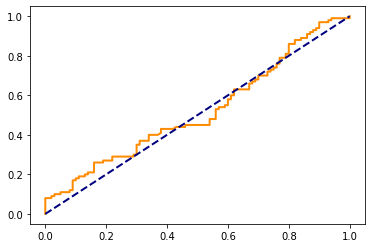

In [59]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [60]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

1.128


We have obtained that our best threshold is at $t = 1.128$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [61]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [62]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.6815    0.5897    0.6323       312
         1.0     0.1351    0.1887    0.1575       106

    accuracy                         0.4880       418
   macro avg     0.4083    0.3892    0.3949       418
weighted avg     0.5429    0.4880    0.5119       418



## SpamBase 4x4 Mixed State

Now, we will work with the SpamBase dataset.

We will do the same work done previously, using both Pure and Mixed States and with both 4x4 and 8x8 density matrices.

Now we transform our data samples into arrays of length 4 and splitting them into training and test samples.

In [63]:
# Create the RandomFourierFeature map
dim = 4
rm_state = 2
sigma = 1  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(spam_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Srff = rffmap.batch2wf(spam_X)

print(Srff.shape)

(3485, 4)


In [64]:
Sones = []
Strain = []
Stest_zeros = []
Stest_ones = []

for i in range(Srff.shape[0]):
    if (spam_y[i] == 1):
        Sones.append(Srff[i] / np.linalg.norm(Srff[i]))
    elif (spam_y[i] == 0):
        Stest_zeros.append(Srff[i] / np.linalg.norm(Srff[i]))

Stest_ones = Sones[:len(Stest_zeros)//2]
Strain = Sones[len(Stest_zeros)//2:]

print(len(Strain))
print(len(Stest_zeros))
print(len(Stest_ones))

2440
697
348


In [65]:
print(Strain[0])
print(sum(Strain[0]**2))

[ 0.35145319 -0.48431271 -0.78982361  0.13453817]
1.0


We build our training density matrix with mixed states:

In [66]:
Z_train = np.outer(np.abs(Strain[0]), np.abs(Strain[0]))
for i in range(1, len(Strain)):
    Z_train += np.outer(np.abs(Strain[i]), np.abs(Strain[i]))

Z_train *= 1/len(Strain)
print(Z_train)

[[0.16023957 0.0855305  0.2371648  0.12718549]
 [0.0855305  0.08410164 0.15276087 0.08057598]
 [0.2371648  0.15276087 0.54511706 0.26604072]
 [0.12718549 0.08057598 0.26604072 0.21054174]]


In [67]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.02850307 0.05355448 0.06531519 0.85262726]
[[-5.62804417e-01  6.84628757e-01 -2.68617322e-01 -3.77331933e-01]
 [ 8.26111187e-01  4.61515842e-01 -2.13519697e-01 -2.42801922e-01]
 [-3.94849885e-04 -5.47471817e-01 -2.93903994e-01 -7.83514452e-01]
 [ 2.81307491e-02  1.36239504e-01  8.92117994e-01 -4.29852234e-01]]


In [68]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.03324847 0.06247062 0.07618934 0.99457888]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [69]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [70]:
## Density Estimation Approach matrices 4x4
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(4, 2)

    qc.initialize(Stest_ones[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Spred_ones.append((counts['00'])/5000)

print(Spred_ones)

[0.9764, 0.0214, 0.019, 0.9304, 0.735, 0.159, 0.4852, 0.4918, 0.7758, 0.5666, 0.1716, 0.9814, 2.4438, 0.5458, 0.3842, 1.1634, 2.5518, 0.1292, 1.6398, 0.028, 0.542, 0.0354, 0.8642, 1.4266, 1.5202, 0.2392, 0.8394, 0.6114, 0.7472, 0.0152, 0.131, 1.0214, 1.0054, 1.4484, 1.0926, 0.2736, 0.338, 1.7228, 0.67, 1.9012, 0.6558, 1.7678, 0.4706, 0.1602, 1.677, 0.3912, 1.0796, 0.1054, 1.0462, 1.4538, 1.3378, 1.7568, 1.2064, 0.6558, 1.713, 0.6394, 2.0798, 0.8506, 0.2676, 0.9722, 0.1546, 0.4394, 0.4306, 0.4436, 0.296, 0.3708, 0.6706, 0.0624, 2.025, 0.6492, 0.967, 0.0234, 0.2838, 0.5844, 0.7006, 0.0456, 0.5172, 0.8418, 0.4338, 1.0728, 1.182, 1.07, 0.3194, 0.767, 0.8324, 0.5714, 1.0416, 0.8434, 0.736, 1.06, 0.263, 1.7964, 1.3652, 1.1164, 0.083, 0.5552, 1.579, 0.6998, 1.526, 1.5936, 1.0404, 1.3176, 1.1704, 1.0238, 2.1232, 0.3124, 0.4736, 1.3384, 0.3258, 0.3482, 0.1952, 1.1976, 0.5344, 0.6128, 1.7738, 2.2356, 0.7102, 1.7312, 1.1268, 0.0436, 1.1164, 1.31, 0.5602, 1.2642, 1.745, 0.6834, 0.4036, 1.1582, 0.7

In [71]:
# Mixed state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(4, 2)
    
    qc.initialize(Stest_zeros[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Spred_zeros.append((counts['00'])/5000)

print(Spred_zeros)

[0.2156, 0.3606, 0.0436, 0.1496, 0.2066, 0.2036, 0.0158, 3.1044, 0.1336, 0.3454, 0.3726, 0.3356, 0.2196, 0.4036, 0.0176, 0.7834, 0.0586, 0.5296, 0.44, 0.0194, 0.4462, 0.0468, 0.0192, 0.1288, 0.6674, 0.0754, 0.7868, 0.5258, 0.0568, 0.064, 0.8208, 0.2622, 0.0216, 0.3928, 0.4178, 0.291, 0.3442, 0.6596, 0.0646, 0.0186, 1.8216, 0.7712, 0.0188, 0.0132, 1.0964, 0.392, 1.0282, 1.3628, 0.0494, 0.0918, 0.0474, 0.0542, 0.1338, 0.7372, 0.4646, 0.4912, 0.0204, 1.3506, 0.1338, 1.1238, 0.0084, 0.3286, 0.0878, 0.0334, 0.5476, 0.3642, 0.9862, 0.2754, 0.1064, 0.083, 0.2706, 0.3434, 0.932, 0.4802, 0.8014, 0.3824, 0.5466, 0.6966, 0.9994, 1.233, 0.885, 0.932, 0.0476, 0.5266, 0.1754, 0.07, 0.1778, 0.0358, 0.1724, 0.42, 0.034, 0.0142, 0.3766, 0.0072, 0.1166, 0.026, 0.5254, 0.0242, 0.9968, 1.101, 0.077, 0.1932, 0.2958, 0.3598, 0.3786, 0.0328, 0.068, 0.4258, 1.2466, 0.5896, 0.4102, 0.4264, 0.0924, 0.0162, 0.6212, 0.047, 0.0212, 0.0316, 0.0086, 0.1494, 0.5156, 0.3574, 0.3154, 0.0262, 0.102, 0.3564, 0.3788, 0.02

We need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. 

In [72]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.7258499999999999


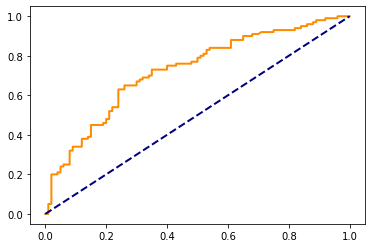

In [73]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [74]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.542


We have obtained that our best threshold is at $t = 0.542$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [75]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [76]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8476    0.7454    0.7932       597
         1.0     0.5250    0.6774    0.5915       248

    accuracy                         0.7254       845
   macro avg     0.6863    0.7114    0.6924       845
weighted avg     0.7529    0.7254    0.7340       845



## SpamBase 4x4 Pure State

We build our training density matrix using Pure States.

In [77]:
phi_train = np.sum(np.abs(Strain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 0.37950892  0.47081098  0.63630529 -0.47898392]
 [ 0.24651561 -0.12507789 -0.6121573  -0.74084345]
 [ 0.77958893 -0.56123548  0.13372207  0.24366829]
 [ 0.43294818  0.66910932 -0.44999715  0.40292823]]


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [78]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [79]:
## Density Estimation Approach matrices 4x4
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Stest_ones[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Spred_ones.append((counts['00'])/5000)
    except:
        Spred_ones.append(0)

print(Spred_ones)

[0.991, 0.0094, 0.0022, 0.916, 0.7104, 0.1416, 0.4866, 0.4696, 0.8048, 0.5458, 0.138, 0.9858, 2.4346, 0.543, 0.3864, 1.1886, 2.581, 0.112, 1.6326, 0.0204, 0.5448, 0.021, 0.8048, 1.4324, 1.5402, 0.2096, 0.8318, 0.6118, 0.7392, 0.0012, 0.1092, 1.016, 1.011, 1.4412, 1.0946, 0.269, 0.3152, 1.7308, 0.6536, 1.937, 0.6486, 1.751, 0.451, 0.1568, 1.6696, 0.406, 1.0796, 0.091, 1.0418, 1.4466, 1.3448, 1.805, 1.23, 0.6428, 1.7196, 0.6314, 2.059, 0.8502, 0.2448, 0.9524, 0.1436, 0.4496, 0.4296, 0.4412, 0.2778, 0.3632, 0.6756, 0.0486, 2.0302, 0.6384, 0.9434, 0.0086, 0.2664, 0.5624, 0.7064, 0.0372, 0.5082, 0.8278, 0.4392, 1.0662, 1.1432, 1.0602, 0.2974, 0.7516, 0.7966, 0.5804, 1.069, 0.8214, 0.6772, 1.0696, 0.2428, 1.7422, 1.3192, 1.0834, 0.0614, 0.5364, 1.5728, 0.6894, 1.5338, 1.5774, 1.0842, 1.2854, 1.1794, 1.0286, 2.1188, 0.2938, 0.4496, 1.3242, 0.2938, 0.3458, 0.1844, 1.1556, 0.5318, 0.5716, 1.7914, 2.2006, 0.6592, 1.7126, 1.1364, 0.0302, 1.0844, 1.2914, 0.5622, 1.278, 1.7476, 0.6552, 0.377, 1.138

In [80]:
# Pure state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Stest_zeros[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Spred_zeros.append((counts['00'])/5000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.1994, 0.3466, 0.039, 0.1376, 0.2048, 0.1986, 0, 3.1662, 0.1142, 0.3322, 0.3788, 0.3246, 0.2044, 0.3908, 0.0108, 0.7788, 0.0512, 0.5198, 0.4514, 0.0054, 0.4592, 0.0468, 0.0078, 0.1198, 0.6582, 0.0654, 0.7822, 0.5348, 0.0454, 0.0518, 0.8216, 0.2322, 0.0078, 0.383, 0.4154, 0.2672, 0.3358, 0.6744, 0.0556, 0.0108, 1.8162, 0.7796, 0.0116, 0.0024, 1.0976, 0.3788, 1.0236, 1.3672, 0.0376, 0.0674, 0.0382, 0.0462, 0.114, 0.7316, 0.4502, 0.4874, 0.0038, 1.3668, 0.1206, 1.1388, 0.0008, 0.3284, 0.0844, 0.0236, 0.5538, 0.348, 0.9748, 0.2622, 0.0938, 0.0684, 0.2568, 0.3398, 0.9408, 0.468, 0.7904, 0.3754, 0.5616, 0.6876, 1.0208, 1.2268, 0.8996, 0.9942, 0.0446, 0.4912, 0.1658, 0.0508, 0.1764, 0.025, 0.1712, 0.3882, 0.0278, 0.0058, 0.3816, 0, 0.1056, 0.0056, 0.505, 0.004, 0.9772, 1.1118, 0.0572, 0.19, 0.2826, 0.353, 0.3726, 0.0214, 0.0558, 0.4222, 1.244, 0.593, 0.4036, 0.4236, 0.0794, 0.0062, 0.6442, 0.0396, 0.0096, 0.0204, 0.0014, 0.1398, 0.5142, 0.3516, 0.2936, 0.011, 0.082, 0.3366, 0.3892, 0.0172, 

We need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. 

In [81]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.7236


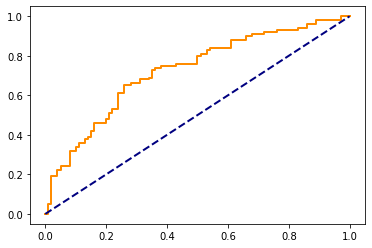

In [82]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [83]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.5198


We have obtained that our best threshold is at $t = 0.5198$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [84]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [85]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8462    0.7370    0.7878       597
         1.0     0.5169    0.6774    0.5864       248

    accuracy                         0.7195       845
   macro avg     0.6815    0.7072    0.6871       845
weighted avg     0.7495    0.7195    0.7287       845



## SpamBase 8x8 Mixed State

We use a new RFF sampler to reduce the data to arrays of lenght 8. Then we split our data as before.

In [86]:
# Create the RandomFourierFeature map
dim = 8
rm_state = 2
sigma = 1  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(spam_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Srff = rffmap.batch2wf(spam_X)

print(Srff.shape)

(3485, 8)


In [87]:
Sones = []
Strain = []
Stest_zeros = []
Stest_ones = []

for i in range(Srff.shape[0]):
    if (spam_y[i] == 1):
        Sones.append(Srff[i] / np.linalg.norm(Srff[i]))
    elif (spam_y[i] == 0):
        Stest_zeros.append(Srff[i] / np.linalg.norm(Srff[i]))

Stest_ones = Sones[:len(Stest_zeros)//2]
Strain = Sones[len(Stest_zeros)//2:]

print(len(Strain))
print(len(Stest_zeros))
print(len(Stest_ones))

2440
697
348


In [88]:
print(Strain[0])
print(sum(Strain[0]**2))

[-0.34027012 -0.40001974 -0.05008387 -0.25346561  0.53922711  0.19674345
  0.2569611  -0.51180502]
1.0


We build our training density matrix using Mixed States.

In [89]:
Z_train = np.outer(np.abs(Strain[0]), np.abs(Strain[0]))
for i in range(1, len(Strain)):
    Z_train += np.outer(np.abs(Strain[i]), np.abs(Strain[i]))

Z_train *= 1/len(Strain)
print(Z_train)

[[0.06931959 0.08300347 0.04808967 0.04941927 0.09431502 0.07784292
  0.08019314 0.10130139]
 [0.08300347 0.15444103 0.07054571 0.07575444 0.15514609 0.13318578
  0.12967983 0.17259092]
 [0.04808967 0.07054571 0.05230964 0.042946   0.07962232 0.06815874
  0.06656479 0.08509469]
 [0.04941927 0.07575444 0.042946   0.06060161 0.08260872 0.07388889
  0.07581426 0.09218323]
 [0.09431502 0.15514609 0.07962232 0.08260872 0.17952542 0.14453548
  0.14385772 0.18738437]
 [0.07784292 0.13318578 0.06815874 0.07388889 0.14453548 0.13756255
  0.12806829 0.15965701]
 [0.08019314 0.12967983 0.06656479 0.07581426 0.14385772 0.12806829
  0.13534703 0.15830969]
 [0.10130139 0.17259092 0.08509469 0.09218323 0.18738437 0.15965701
  0.15830969 0.21089312]]


In [90]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.00549852 0.00671934 0.00996441 0.97781773 0.01365931 0.01958209
 0.02544983 0.90645963]
[[ 0.00771802  0.15422668  0.42740079 -0.35756528 -0.30143132 -0.48259314
  -0.53267092  0.24111181]
 [-0.38476255 -0.19726171  0.43203748 -0.1121561   0.51696029 -0.16943225
   0.40003892  0.39727051]
 [ 0.07079513 -0.30775459 -0.04294226  0.73889489  0.23821596 -0.24075563
  -0.44276533  0.20424057]
 [-0.05922746  0.22554943 -0.22932215 -0.31234088  0.5380915   0.44017573
  -0.51343091  0.22037617]
 [-0.39890327  0.27235547 -0.64369821  0.03250565 -0.19428076 -0.32603283
   0.13665694  0.4342547 ]
 [ 0.00397229  0.54380302  0.37682723  0.41728872 -0.2362154   0.42731713
   0.09596151  0.37487011]
 [-0.17092392 -0.64697815 -0.03151477 -0.13364449 -0.44248959  0.43475375
  -0.10042811  0.37209755]
 [ 0.8093354  -0.05689074 -0.1374779  -0.15165173  0.07913371 -0.09365077
   0.24209212  0.47560492]]


In [91]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.00412226 0.00503751 0.00747034 0.7330724  0.01024042 0.01468074
 0.0190798  0.67957505]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|000 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [92]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [93]:
## Density Estimation Approach matrices 8x8
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Stest_ones[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Spred_ones.append((counts['000'])/5000)

print(Spred_ones)

[0.0282, 0.0442, 1.0824, 0.3134, 0.0394, 0.126, 0.137, 0.1578, 0.0274, 0.0282, 0.553, 0.1374, 0.1772, 0.1662, 0.0214, 0.2392, 0.2206, 0.1682, 0.0674, 0.0444, 0.238, 0.7854, 0.0962, 0.0734, 0.1704, 0.3772, 0.0156, 0.1218, 0.0378, 0.5754, 0.0912, 0.0276, 0.034, 0.0236, 0.0616, 0.3986, 0.139, 0.2224, 0.0428, 0.132, 0.8388, 0.0458, 0.1152, 0.3714, 0.1868, 0.0022, 0.4374, 0.4178, 0.4038, 0.27, 0.0116, 0.0064, 0.0864, 0.0776, 0.0524, 0.0398, 0.2716, 0.1828, 0.2048, 0.13, 0.847, 0.0418, 0.038, 0.1248, 0.1804, 0.6152, 0.245, 0.8274, 0.0466, 0.497, 0.099, 0.129, 0.3906, 0.0474, 0.1092, 0.4198, 0.1526, 0.2362, 0.0628, 0.1794, 0.0762, 0.0686, 0.1648, 0.0262, 0.0398, 0.0228, 0.4664, 0.081, 0.184, 0.4494, 0.3212, 0.0416, 0.1544, 0.877, 1.1342, 0.1304, 0.0298, 0.251, 0.0438, 0.2578, 0.451, 0.0122, 0.1348, 0.0422, 0.0086, 0.1138, 0.264, 0.2352, 0.6444, 0.5942, 0.8058, 0.011, 0.1658, 0.0556, 0.0556, 0.0246, 0.0632, 0.0284, 0.1278, 0.9456, 0.142, 0.041, 0.0566, 0.0658, 0.1738, 0.018, 0.0608, 0.0828, 0.

In [94]:
# Mixed state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Stest_zeros[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    counts = execute(qc, backend2, shots=20000).result().get_counts()
    try:
        Spred_zeros.append((counts['000'])/5000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.0616, 0.02, 0.0596, 0.1126, 0.1856, 0.0788, 0.8884, 0.144, 0.043, 0.0278, 0.232, 0.0136, 0.014, 0.2666, 0.1744, 0.1472, 0.4238, 0.0456, 0.2086, 0.4572, 0.0384, 0.3562, 0.21, 0.1102, 0.1384, 0.201, 0.0196, 0.0486, 0.3134, 0.2972, 0.0154, 0.0126, 0.8714, 0.0606, 0.0458, 0.0186, 0.4808, 0.1086, 0.1412, 0.3704, 0.0092, 0.261, 0.0056, 0.116, 0.0346, 0.0004, 0.649, 0.057, 0.016, 0.6096, 0.0406, 0.1456, 0.119, 0.3538, 0.0214, 0.1672, 0.0782, 0.0222, 0.3208, 0.2108, 0.3198, 0.4384, 0.0044, 0.005, 0.0086, 0.6886, 0.2306, 0.0202, 0.1014, 0.0908, 0.1164, 0.0602, 0.1032, 0.1862, 0.0034, 0.0544, 0.0064, 0.0208, 0.8406, 0.029, 0.1106, 0.4398, 0.096, 0.036, 0.2546, 0.0826, 0.0166, 0.223, 0.2656, 0.1222, 0.1074, 0.1356, 0.044, 0.1108, 0.0002, 0.0316, 0.0894, 0.5982, 0.7574, 0.1582, 0.1666, 0.102, 0.0444, 0.1542, 0.1554, 0.0612, 0.346, 0.1168, 0.1824, 0.02, 0.0638, 0.0582, 0.0248, 0.0448, 0.0314, 0.095, 0.4242, 0.0614, 0.0744, 0.0632, 0.0806, 0.115, 0.0314, 0.0638, 0.1242, 0.4748, 0.006, 0.022, 0.22

We need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. 

In [95]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.56865


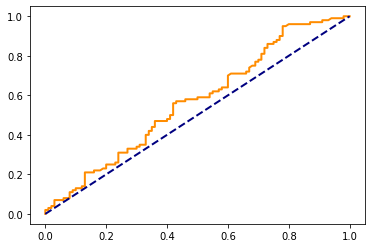

In [96]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [97]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.1222


We have obtained that our best threshold is at $t = 0.1222$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [98]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [99]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.7620    0.5846    0.6616       597
         1.0     0.3592    0.5605    0.4378       248

    accuracy                         0.5775       845
   macro avg     0.5606    0.5725    0.5497       845
weighted avg     0.6438    0.5775    0.5959       845



## SpamBase 8x8 Pure State

We build our training density matrix using Pure States.

In [100]:
phi_train = np.sum(np.abs(Strain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 2.42533676e-01  3.92465306e-01 -6.70307607e-01  2.91091225e-01
   2.67895241e-01 -4.20590156e-01 -6.43884790e-02 -1.70937208e-02]
 [ 3.96977281e-01 -1.22555550e-01  3.64045805e-02  2.60429951e-02
  -6.95863502e-01 -2.91149292e-01 -5.06351380e-01 -3.63535790e-05]
 [ 2.06555201e-01  1.73205406e-01 -2.28882531e-01  7.00712557e-02
  -2.51969816e-01  5.40217153e-01  1.42867681e-01 -7.03066929e-01]
 [ 2.22028386e-01  5.51803480e-01  6.94026834e-01  2.93379612e-01
   1.23616632e-01 -1.80470956e-01  3.93990677e-02 -1.70494422e-01]
 [ 4.33649605e-01  3.06048557e-01 -5.08853786e-03 -7.41394147e-01
   2.34198061e-01  2.05822626e-01 -2.12803105e-01  1.61537237e-01]
 [ 3.73541690e-01 -5.31680987e-01  1.05928774e-01  2.79501890e-01
   5.36466451e-01  1.51244397e-01 -3.80668763e-01 -1.81272982e-01]
 [ 3.71143602e-01  6.25581780e-02 -4.59237958e-02  3.98627595e-01
  -1.48527718e-01  4.65894247e-01  2.29219143e-01  6.36919617e-01]
 [ 4.75701431e-01 -3.40881226e-01  4.41153768e-02 -1.92134164e-01
  -

We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [101]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [102]:
## Density Estimation Approach matrices 8x8
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Stest_ones[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Spred_ones.append((counts['000'])/5000)
    except:
        Spred_ones.append(0)

print(Spred_ones)

[0.0246, 0, 0.0604, 0.0026, 0.0012, 0.0626, 0.0152, 0.0104, 0.0012, 0.017, 0.0066, 0.0002, 0.0928, 0.0296, 0.022, 0.156, 0.4428, 0.0486, 0.1302, 0.0822, 0.4706, 1.615, 0.002, 0.1304, 0.0062, 0.0094, 0.0214, 0.0068, 0.0134, 0.761, 0.018, 0.0686, 0.0194, 0.0054, 0.0092, 0.0022, 0.0002, 0.0164, 0.0904, 0.2304, 0.1412, 0.004, 0.0536, 0.0046, 0.0874, 0.0092, 0.7992, 0.5146, 0.074, 0.4646, 0.0022, 0, 0.0226, 0.0256, 0.0626, 0.003, 0.2378, 0.0028, 0.0052, 0.2408, 1.519, 0.0218, 0.0236, 0.0006, 0, 1.071, 0.0366, 1.5064, 0.083, 0.0568, 0.0044, 0.01, 0.0156, 0.0148, 0.0052, 0.0696, 0.0064, 0.2972, 0.0094, 0.0152, 0.0012, 0.0002, 0.0208, 0.0536, 0.0152, 0.0046, 0.8544, 0.1378, 0.0344, 0.8454, 0.0252, 0.016, 0.3432, 0.0092, 1.8166, 0.0074, 0.0126, 0.0324, 0.0058, 0.064, 0.8298, 0, 0.0738, 0.0066, 0.0076, 0.0038, 0.0014, 0.0712, 0.533, 1.054, 1.2136, 0.0076, 0.2522, 0.0856, 0.013, 0.046, 0.027, 0.0356, 0.1044, 1.2682, 0.0572, 0.0178, 0.001, 0.0276, 0.0032, 0.0034, 0.0162, 0.0976, 0.0054, 0.0098, 0.

In [103]:
# Pure state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Stest_zeros[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Spred_zeros.append((counts['000'])/5000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.0636, 0.023, 0.036, 0.0396, 0.0112, 0.041, 0.0174, 0.1252, 0.0438, 0.0006, 0.0216, 0.0002, 0.003, 0.2998, 0.0648, 0.0756, 0.2608, 0.0772, 0.0364, 0.0424, 0.0684, 0.0008, 0.0062, 0.0604, 0.086, 0.0948, 0.0302, 0.0756, 0.007, 0, 0.0002, 0.025, 0.001, 0.1122, 0.0026, 0.0274, 0.1362, 0.0386, 0.0016, 0.057, 0.007, 0.0724, 0.0094, 0.0014, 0, 0, 0.1166, 0.0278, 0.015, 0.1096, 0.0026, 0.0008, 0.0004, 0.1416, 0.002, 0, 0.0194, 0.001, 0.055, 0.447, 0.0544, 0.1132, 0.0042, 0.0004, 0, 0.0724, 0.0346, 0.009, 0.001, 0.067, 0.1576, 0.0238, 0.2234, 0.0322, 0.0076, 0.111, 0.0118, 0.0376, 0.0478, 0.0006, 0.0262, 0.0474, 0.0154, 0.0616, 0.0252, 0.0334, 0.0014, 0.0342, 0.0194, 0.0012, 0.026, 0.0138, 0.004, 0.2384, 0, 0.0604, 0.1152, 0.285, 0.0242, 0.2776, 0.0604, 0.171, 0, 0.0454, 0.053, 0.079, 0.0182, 0.0002, 0.291, 0.0052, 0.1194, 0.112, 0.0028, 0.0824, 0.0208, 0.0724, 0.5996, 0.0584, 0.0632, 0.0004, 0.0036, 0.0126, 0.0038, 0.0278, 0.0212, 0.99, 0.001, 0.0092, 0.1216, 0.0172, 0.0038, 0.0948, 0.0184, 

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [104]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.5292


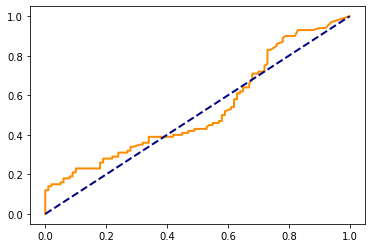

In [105]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [106]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.0616


We have obtained that our best threshold is at $t = 0.0616$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [107]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [108]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.6988    0.6566    0.6770       597
         1.0     0.2782    0.3185    0.2970       248

    accuracy                         0.5574       845
   macro avg     0.4885    0.4876    0.4870       845
weighted avg     0.5753    0.5574    0.5655       845

